In [623]:
import pennylane as qml
from pennylane import numpy as np
from IPython.display import display, Latex

# from numba import jit

# numpy 
import numpy as np_

import matplotlib.pyplot as plt

# 2-qubit
dev = qml.device('default.mixed', wires= 2)
# dev_new = qml.device('default.qubit', wires=2)

# == Hamiltonian setup == 
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)

In [624]:
Tau_global, Phi_global = np.zeros(3), 0
Gamma_ps_global = 0

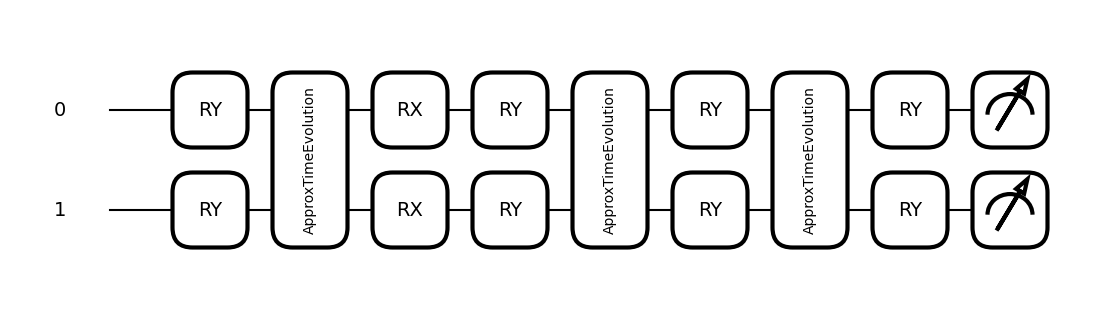

In [625]:
# 1-layer
@qml.qnode(dev)
def circuit_alt(phi_in):
    global Tau_global, Phi_global
    
    theta_init, tau_1, tau_2 = np.array([-4.30345750e-004, -4.71229702e-004,7.74495267e-001]) # 1.52495664e+00, 5.36475885e+00, 9.91001330e+00
    phi = phi_in
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, -tau_1/2, 1)
    
    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, -tau_2/2, 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(hamiltonian, -phi/2, 1)
    
    # qml.RX(np.pi/(2 + 1e-6), wires=0)
    # qml.RX(np.pi/(2 + 1e-6), wires=1)
    
    qml.RY(-np.pi/(2 + 1e-6), wires=0)
    qml.RY(-np.pi/(2 + 1e-6), wires=1)
    
    return qml.density_matrix(wires=[0, 1])

fig, ax = qml.draw_mpl(circuit_alt)(0)

In [626]:
@qml.qnode(dev)
def Post_selection_alt(phi):
    global Gamma_ps_global
    Gamma_ps = Gamma_ps_global
        
    # Get density matrix from circuit_2
    density_matrix = np.zeros((4, 4), dtype=np.complex128)
    density_matrix = circuit_alt(phi)
    
    qml.QubitDensityMatrix(density_matrix, wires=[0, 1])
    
    # # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    I = np.eye(2)
    
    # Numerator = np.kron(K, K) @ density_matrix @ np.kron(K_H, K_H)
    Numerator = np.kron(K,I) @ density_matrix @ np.kron(K,I).conj().T
    Denominator = np.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires=[0, 1])
    
    return qml.density_matrix(wires=[0, 1])

In [627]:
def Sweep(Sweep_bound, Gamma_ps_in):
    
    PHI = np.arange(Sweep_bound[0], Sweep_bound[1], Sweep_bound[2]).reshape(-1, 1)
    
    Data = np.zeros((len(PHI), 1 + len(Gamma_ps_in)))
    Data[:, 0] = PHI.squeeze()
    
    GAMMA_INDEX_IN_DATA = 1
    
    global Gamma_ps_global
    
    for Gamma_index in range(len(Gamma_ps_in)):
        Gamma_ps_global = Gamma_ps_in[Gamma_index]
        
        for i in range(len(PHI)):
            Data[i][Gamma_index + GAMMA_INDEX_IN_DATA] = qml.qinfo.classical_fisher(Post_selection_alt)(PHI[i])
        
    return Data

In [628]:
Sweep_data = np.arange(1e-4, np.pi * 5 + 1e-4, 1e-2)
CFI_DATA = np.zeros(len(Sweep_data))

Gamma_ps_global = 0.8


for i in range(len(Sweep_data)):
    CFI_DATA[i] = qml.qinfo.classical_fisher(Post_selection_alt)(Sweep_data[i])

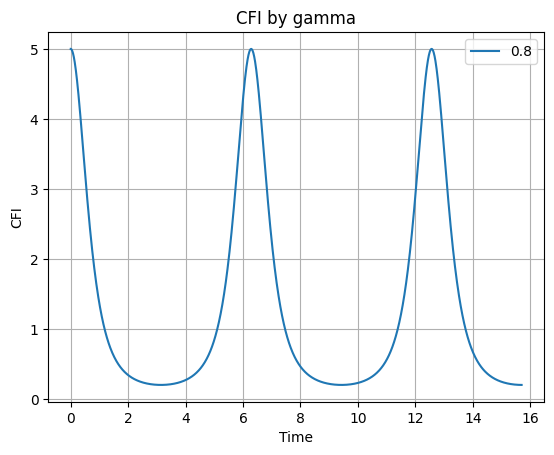

In [629]:
plt.plot(Sweep_data, CFI_DATA, label = 0.8)

plt.title('CFI by gamma')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid() 

In [630]:
Sweep_data = np_.array([1e-4, np.pi * 4 + 1e-4, 1e-2])
Gamma_ps_desired = 0.3, 0.4, 0.6, 0.7

Result = Sweep(Sweep_data, Gamma_ps_desired)

print(Result)

[[1.00000000e-04 1.42856968e+00 1.66666459e+00 2.49999675e+00
  3.33332881e+00]
 [1.01000000e-02 1.42854305e+00 1.66661516e+00 2.49982617e+00
  3.33297281e+00]
 [2.01000000e-02 1.42845349e+00 1.66645264e+00 2.49927776e+00
  3.33183554e+00]
 ...
 [1.25401000e+01 1.42835255e+00 1.66626947e+00 2.49865976e+00
  3.33055419e+00]
 [1.25501000e+01 1.42848563e+00 1.66651096e+00 2.49947455e+00
  3.33224361e+00]
 [1.25601000e+01 1.42855751e+00 1.66664141e+00 2.49991477e+00
  3.33315657e+00]]


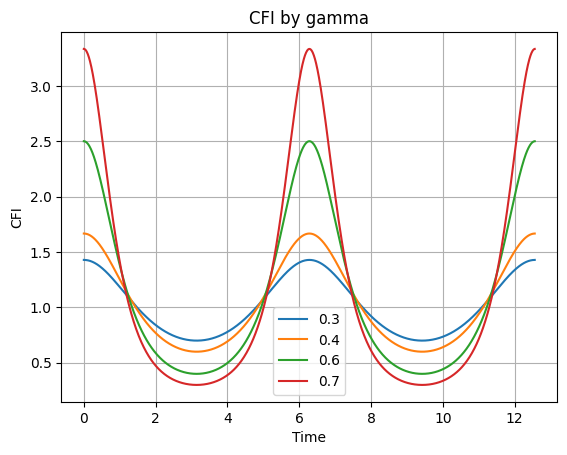

In [631]:
plt.plot(Result[:,0], Result[:,1], label = 0.3)
plt.plot(Result[:,0], Result[:,2], label = 0.4)
plt.plot(Result[:,0], Result[:,3], label = 0.6)
plt.plot(Result[:,0], Result[:,4], label = 0.7)
# plt.plot(Result[:,0], Result[:,4], label = 0.6)

plt.title('CFI by gamma')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid() 

In [632]:
import random

array = np_.zeros(4)

array[:4] = random.uniform(0,1)

array = np_.round(array, 3)
array = np.array(array)

array

tensor([0.233, 0.233, 0.233, 0.233], requires_grad=True)

In [633]:
Sweep_data = np_.array([1e-4, np.pi * 3 + 1e-4, np.pi/(25*2)])
Gamma_ps_desired = 0.6, 0.7

Result = Sweep(Sweep_data, Gamma_ps_desired)

# print(Result)

# Result[:,0]

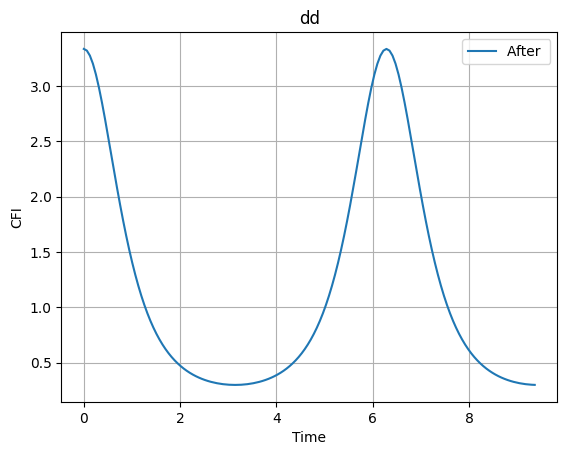

In [634]:
plt.plot(Result[:, 0], Result[:, 2], label = 'After ')
    
plt.title('dd')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid() 